## 1. Import packages and data and create the dataframe

### 1.1 Packages/loger

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import plotnine as p9
import logging
import matplotlib.pyplot as plt
#from plotnine import *
#from plotnine.data import *

%matplotlib inline

In [4]:
from functools import wraps 

def log_step(func): 
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        shape_before = args[0].shape
        shape_after = result.shape
        print(f"{func.__name__} => before shape:{shape_before} after shape:{shape_after}")
        return result
    return wrapper

logging.getLogger().setLevel(logging.DEBUG)

### 1.2 Import data

In [10]:
df_domoticz = pd.read_csv('//raspberrypi/pi/domoticz/data/logging.csv')

In [7]:
df_month = pd.DataFrame([["(01) Jan", 1], ["(02) Feb", 2], ["(03) Mar", 3], ["(04) Apr", 4], 
                         ["(05) May", 5], ["(06) Jun", 6], ["(07) Jul", 7], ["(08) Aug", 8], 
                         ["(09) Sep", 9], ["(10) Oct", 10], ["(11) Nov", 11], ["(12) Dec", 12]], 
                        columns=["month", "number"])

month = dict(zip(df_month.number, df_month.month))

df_day = pd.DataFrame([["(0) Sunday", 0] , ["(1) Monday", 1], ["(2) Tuesday", 2], ["(3) Wednesday", 3],
                       ["(4) Thursday", 4], ["(5) Friday", 5], ["(6) Saturday", 6]],
                      columns=["day", "number"])

day = dict(zip(df_day.number, df_day.day))

### 1.3 Create dataframe

In [45]:
@log_step 
def start_pipeline(dataf):
    return dataf

@log_step
def create_date(dataf):
    return (dataf
            .assign(datetime=lambda d: pd.to_datetime(d['Timestamp'], format="%d-%m-%Y %H:%M:%S"),
                    date=lambda d: pd.to_datetime(d['datetime'].dt.date)
                   )
            .drop(columns=['Timestamp'])
           )

@log_step
def remove_datetime(dataf):
    return dataf.drop(columns=['datetime'])

@log_step
def create_df(dataf):
    dataf = (
        dataf[['date',  'Meter_Gas', 'Dagverbruik_Gas']]
        .rename(columns={"Meter_Gas": "meter_reading", "Dagverbruik_Gas": "gas_usage"})
        .dropna(subset=['meter_reading'])
        .reset_index()
        #.assign(gas_usage=lambda d: d['meter_reading']-d['meter_reading'].shift(1))
        .drop(columns=['index'])
    )
    return dataf

df_domoticz[['Timestamp', 'Meter_Gas', 'Dagverbruik_Gas']].dropna(subset=['Meter_Gas',]).head(60)


@log_step
def date_to_index(dataf):
    return dataf.set_index('date')

# Create dataframe gas usage
df_gas = (
    df_domoticz
    .pipe(start_pipeline)
    .pipe(create_date)
    .pipe(remove_datetime)
    .pipe(create_df)
    .pipe(date_to_index)
)

df_gas.sample(5)

start_pipeline => before shape:(415542, 28) after shape:(415542, 28)
create_date => before shape:(415542, 28) after shape:(415542, 29)
remove_datetime => before shape:(415542, 29) after shape:(415542, 28)
create_df => before shape:(415542, 28) after shape:(6772, 3)
date_to_index => before shape:(6772, 3) after shape:(6772, 2)


,meter_reading,gas_usage
date,,
2019-03-03,1031.284,NaN
2019-09-01,1442.120,NaN
2019-08-23,1432.166,1.004
2019-10-14,1523.806,NaN
2019-05-03,1283.083,NaN


# 2 Investigation

### 2.1 Usage of gas daily based

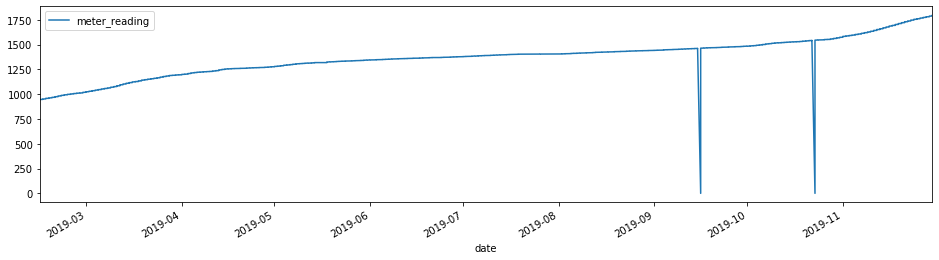

In [46]:
df_gas[['meter_reading']].plot(figsize=(16, 4))

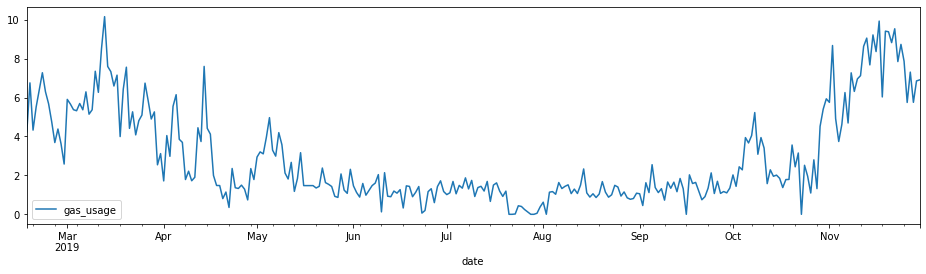

In [48]:
(
    df_gas[['gas_usage']]
    .dropna()
    .plot(figsize=(16, 4))
)

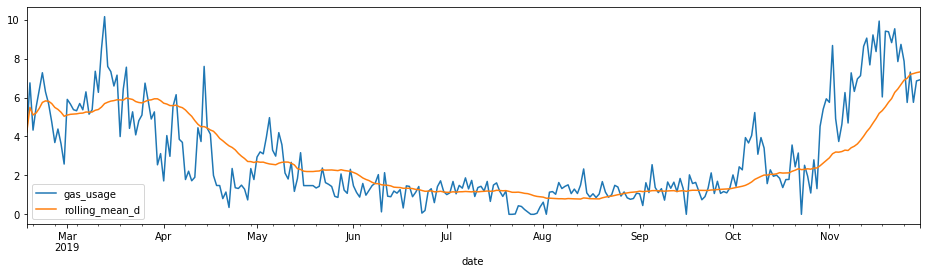

In [49]:
(
    df_gas[['gas_usage']]
    .dropna()
    .assign(rolling_mean_d=lambda d: d['gas_usage']
            .rolling("30D")
            .mean()
           )
    .plot(figsize=(16,4))
)

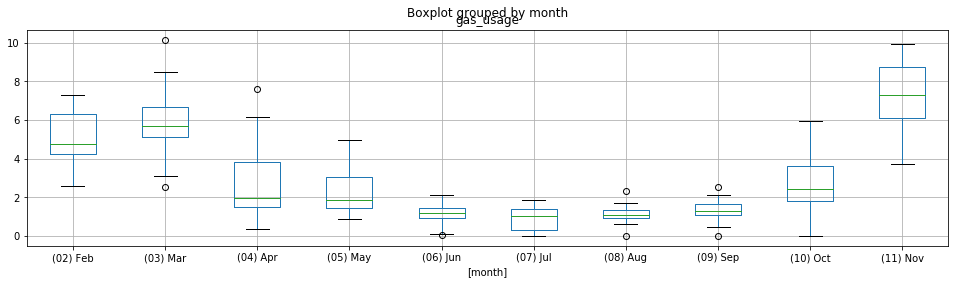

In [50]:
(
    df_gas[['gas_usage']]
    .dropna()
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month.map(month))
    .drop(['date'], axis=1)
    .set_index('month')
    .boxplot(by=['month'], figsize=(16,4))
)

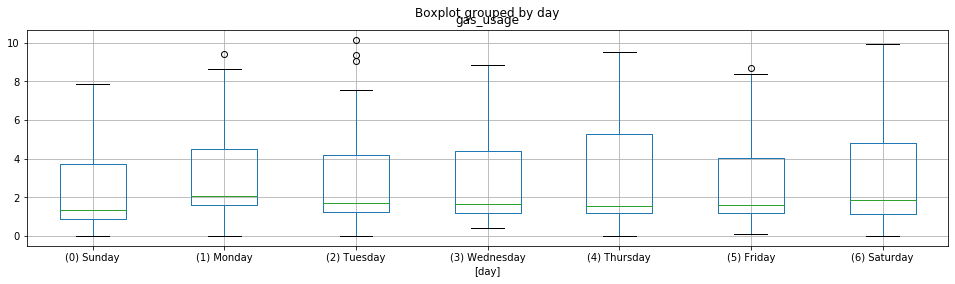

In [51]:
(
    df_gas[['gas_usage']]
    .dropna()
    .reset_index()
    .assign(day=lambda d: d['date'].dt.weekday.map(day))
    .drop(['date'], axis=1)
    .set_index('day')
    .boxplot(by=['day'], figsize=(16,4))
)

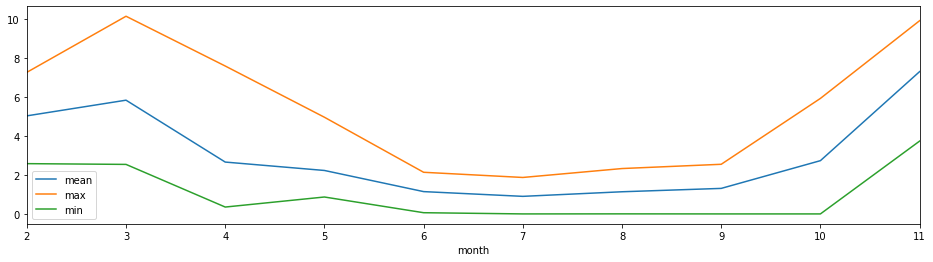

In [55]:
mean=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"mean": np.mean(d['gas_usage'])}))
)

maximum=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"max": np.max(d['gas_usage'])}))
)

minimal=(
    df_gas
    .reset_index()
    .assign(month=lambda d: d['date'].dt.month)
    .groupby('month')
    .apply(lambda d: pd.Series({"min": np.min(d['gas_usage'])}))
)

(
   mean
    .join(maximum)
    .join(minimal)
    .plot(figsize=(16, 4))
)

del mean
del maximum
del minimal